# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/home/rco/github/s_metaheuristic/data/log


In [26]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [27]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [28]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [29]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [30]:
all_dfs = []
best_dfs = []
LOGs = str(LOG_PATH) + '/*.csv'

c = 0
for file in glob.glob(str(LOGs)):
    filename = file[file.find('/log/')+5:]
    try:
        df = pd.read_csv(file, low_memory=False, sep=',', quotechar='"')
        c = c + 1
    except:
        print('Arquivo não importado: {}'.format(filename))
    df['filename'] = filename
    df['Z'] = df.Z.apply(lambda x: literal_eval(x))
    df['X'] = df.X.apply(lambda x: literal_eval(x))
    df['k'] = df.Z.apply(lambda x: len(x))
    all_dfs.append(df)
    best_dfs.append(df.iloc[-1:])

all_data = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
all_data.rename({'move_strategy':'move_str',
                 'selection_strategy':'selec_str'}, axis=1, inplace=True)

best_data = pd.concat(best_dfs, ignore_index=True).reset_index(drop=True)
best_data.rename({'move_strategy':'move_str',
                  'selection_strategy':'selec_str'}, axis=1, inplace=True)

print('Importados {} arquivos'.format(c))

# for col in all_data.columns:
#     all_data[col] = pd.to_numeric(all_data[col])

# for col in best_data.columns:
#     best_data[col] = pd.to_numeric(best_data[col])

Importados 870 arquivos


In [31]:
all_data.Z

0                 [1, 3, 19, 20, 21, 22, 27]
1                  [1, 3, 4, 19, 20, 21, 27]
2                  [1, 3, 4, 13, 20, 21, 27]
3                  [1, 4, 6, 13, 20, 21, 27]
4                  [1, 4, 6, 13, 20, 27, 29]
                         ...                
124749    [4, 8, 12, 13, 18, 19, 25, 27, 29]
124750    [4, 8, 12, 13, 18, 19, 25, 27, 29]
124751    [4, 8, 12, 13, 18, 19, 25, 27, 29]
124752    [4, 8, 12, 13, 18, 19, 25, 27, 29]
124753    [4, 8, 12, 13, 18, 19, 25, 27, 29]
Name: Z, Length: 124754, dtype: object

In [32]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124754 entries, 0 to 124753
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   iter        124754 non-null  int64  
 1   move        124754 non-null  object 
 2   improve     124754 non-null  bool   
 3   obj         124754 non-null  float64
 4   return      124754 non-null  float64
 5   n_assets    124754 non-null  int64  
 6   qX          124754 non-null  int64  
 7   qN          124754 non-null  int64  
 8   qNv         124754 non-null  int64  
 9   iter_time   124754 non-null  float64
 10  max_iter    124754 non-null  int64  
 11  neighbours  124754 non-null  int64  
 12  alpha       124754 non-null  float64
 13  exp_return  124754 non-null  float64
 14  n_port      124754 non-null  int64  
 15  k_min       124754 non-null  int64  
 16  k_max       124754 non-null  int64  
 17  move_str    124754 non-null  object 
 18  seed        124754 non-null  int64  
 19  se

In [33]:
all_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
iter,124754.0,NaN,NaN,NaN,111.961123,114.058249,0.0,35.0,73.0,148.0,648.0
move,124754,3,TID,59471,NaN,NaN,NaN,NaN,NaN,NaN,NaN
improve,124754,2,True,73821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
obj,124754.0,NaN,NaN,NaN,0.061795,0.059464,0.000293,0.014348,0.040318,0.099611,0.235202
return,124754.0,NaN,NaN,NaN,0.004394,0.002285,0.001,0.002521,0.004328,0.005182,0.010804
n_assets,124754.0,NaN,NaN,NaN,7.354963,3.614871,2.0,5.0,7.0,9.0,15.0
qX,124754.0,NaN,NaN,NaN,7.354963,3.614871,2.0,5.0,7.0,9.0,15.0
qN,124754.0,NaN,NaN,NaN,100.0,0.0,100.0,100.0,100.0,100.0,100.0
qNv,124754.0,NaN,NaN,NaN,61.279157,22.446609,0.0,47.0,60.0,76.0,100.0
iter_time,124754.0,NaN,NaN,NaN,0.041729,0.022175,0.015452,0.032599,0.034414,0.03701,0.228784


## Portfólios

### Geral

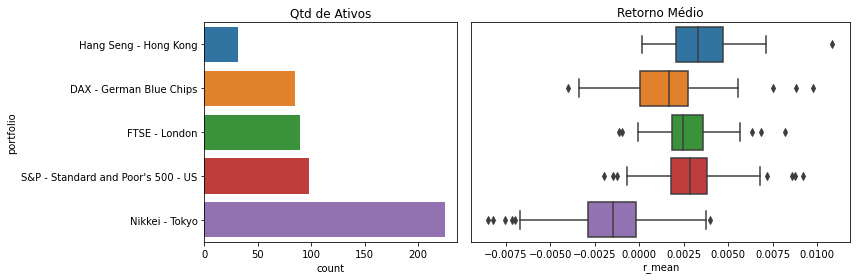

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

### Matriz de Covariância

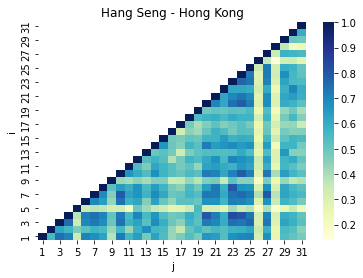

In [35]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [36]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


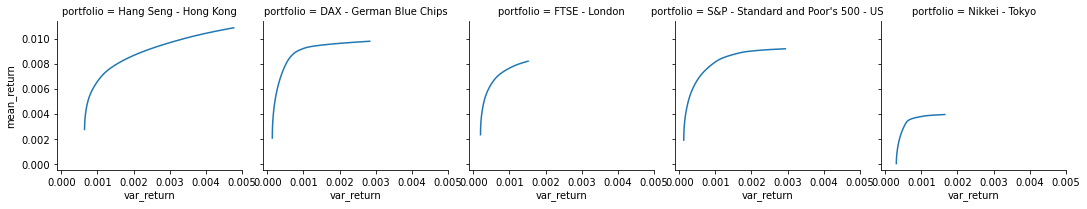

In [37]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

### Avaliação do Impacto da Seed

In [38]:
# g = sns.FacetGrid(
#     data=all_data, row='seed', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

In [39]:
# g = sns.FacetGrid(
#     data=all_data, row='seed', col='selec_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Tipo de Move

In [40]:
# g = sns.FacetGrid(
#     data=all_data, row='selec_str', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Impacto do Retorno Experado

In [41]:
# g = sns.FacetGrid(
#     data=all_data, row='exp_return', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

## Análise Best - Portfólio 1

In [42]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [43]:
print(best_data.shape)
best_data.head()

(870, 25)


,iter,move,improve,obj,return,n_assets,qX,qN,qNv,iter_time,...,k_min,k_max,move_str,seed,selec_str,tag,X,Z,filename,k
0,68,idID,False,0.003177,0.002503,2,2,100,49,0.033963,...,2,15,idID,1,best,ccef,"[0.019377, 0.980623]","[4, 27]",log_local_search_20211102_143232_594882.csv,2
1,183,iDR,False,0.025090,0.010368,8,8,100,50,0.034872,...,2,15,iDR,9,best,ccef,"[0.010504, 0.927076, 0.010193, 0.010441, 0.010...","[3, 4, 5, 7, 9, 18, 23, 25]",log_local_search_20211102_143219_051847.csv,8
2,67,iDR,False,0.001380,0.002361,2,2,100,99,0.099943,...,2,15,best,0,best,ccef,"[0.01, 0.989257]","[25, 27]",log_local_search_20211102_142817_984242.csv,2
3,66,idID,False,0.001384,0.002363,2,2,100,67,0.034038,...,2,15,idID,1,best,ccef,"[0.010022, 0.989978]","[25, 27]",log_local_search_20211102_142935_954764.csv,2
4,97,TID,False,0.001454,0.004767,2,2,100,99,0.034404,...,2,15,random,7,best,ccef,"[0.989467, 0.010533]","[25, 27]",log_local_search_20211102_143103_356931.csv,2


In [44]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,870.0,142.395402,1.081852e+02,50.000000,71.000000,97.000000,171.750000,648.000000
obj,870.0,0.023886,4.373075e-02,0.000293,0.001655,0.003065,0.026492,0.218159
return,870.0,0.004449,2.628661e-03,0.001000,0.002364,0.004627,0.005262,0.010780
n_assets,870.0,4.782759,3.312969e+00,2.000000,2.000000,2.000000,7.000000,15.000000
qX,870.0,4.782759,3.312969e+00,2.000000,2.000000,2.000000,7.000000,15.000000
qN,870.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000
qNv,870.0,62.194253,2.515229e+01,0.000000,49.000000,61.000000,79.000000,100.000000
iter_time,870.0,0.048178,2.874976e-02,0.018516,0.033390,0.034518,0.036464,0.204237
max_iter,870.0,1000.000000,0.000000e+00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
neighbours,870.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000


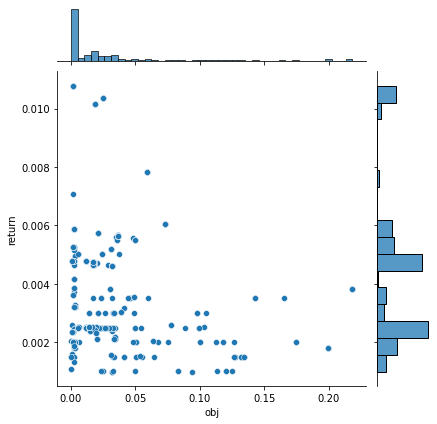

In [56]:
sns.jointplot(data=best_data, x='obj', y='return', palette='bright')

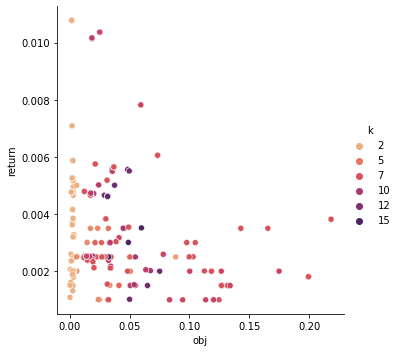

In [63]:
sns.relplot(data=best_data, x='obj', y='return', hue='k', palette='flare')

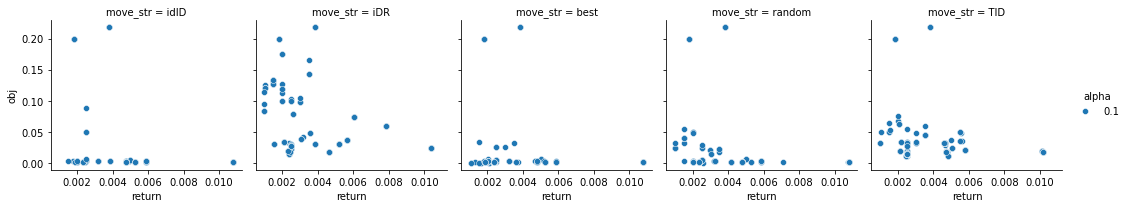

In [46]:
g = sns.FacetGrid(data=best_data, col='move_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

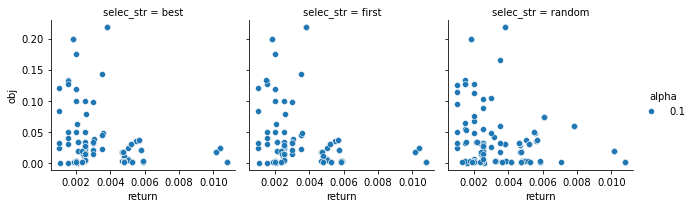

In [47]:
g = sns.FacetGrid(data=best_data, col='selec_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

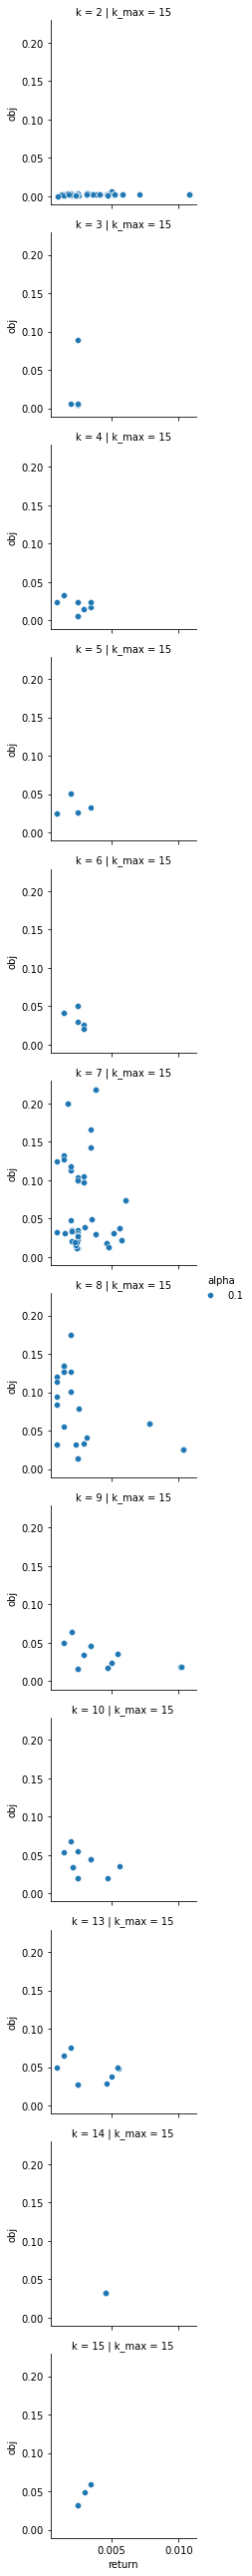

In [48]:
g = sns.FacetGrid(data=best_data, hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

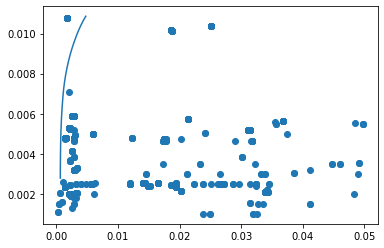

In [49]:
data = best_data[best_data['obj']<0.05]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])

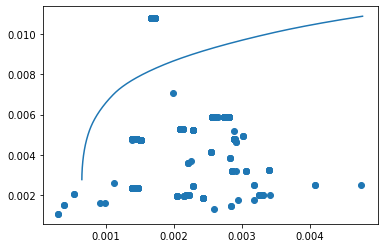

In [50]:
data = best_data[best_data['obj']<0.005]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])

In [51]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return          0.0010  0.0015  0.0020  0.0025  0.0030  0.0035  0.0040  \
move_str selec_str                                                           
TID      best           10      10      10       8       6       6       4   
         first          10      10      10       8       6       6       4   
         random         10      10      10       8       6       6       4   
best     best           10      10      10       8       6       6       4   
         first          10      10      10       8       6       6       4   
         random         10      10      10       8       6       6       4   
iDR      best           10      10      10       8       6       6       4   
         first          10      10      10       8       6       6       4   
         random         10      10      10       8       6       6       4   
idID     best           10      10      10       8       6       6       4   
         first          10      10      10       8       6       6       4   
         random         10      10      10       8       6       6       4   
random   best           10      10      10       8       6       6       4   
         first          10      10      10       8       6       6       4   
         random         10      10      10       8       6       6       4   

exp_return          0.0045  0.0050  0.0055  
move_str selec_str                          
TID      best            2       1       1  
         first           2       1       1  
         random          2       1       1  
best     best            2       1       1  
         first           2       1       1  
         random          2       1       1  
iDR      best            2       1       1  
         first           2       1       1  
         random          2       1       1  
idID     best            2       1       1  
         first           2       1       1  
         random          2       1       1  
random   best            2       1       1  
         first           2       1       1  
         random          2       1       1

In [52]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return            0.0010    0.0015    0.0020    0.0025    0.0030  \
move_str selec_str                                                     
TID      best       0.011926  0.011926  0.011926  0.012009  0.012282   
         first      0.011926  0.011926  0.011926  0.012009  0.012282   
         random     0.014382  0.014382  0.014382  0.014382  0.017765   
best     best       0.000293  0.000386  0.000532  0.001381  0.001381   
         first      0.000293  0.000386  0.000532  0.001381  0.001381   
         random     0.001380  0.000916  0.001380  0.001655  0.001380   
iDR      best       0.014820  0.014820  0.014820  0.022273  0.017292   
         first      0.014820  0.014820  0.014820  0.022273  0.017292   
         random     0.015232  0.015232  0.015232  0.025184  0.017822   
idID     best       0.001384  0.001384  0.001384  0.001386  0.001381   
         first      0.001384  0.001384  0.001384  0.001386  0.001381   
         random     0.001381  0.001381  0.001381  0.001381  0.001381   
random   best       0.001391  0.001391  0.001391  0.001391  0.001391   
         first      0.001391  0.001391  0.001391  0.001391  0.001391   
         random     0.001382  0.001381  0.001382  0.001110  0.001381   

exp_return            0.0035    0.0040    0.0045    0.0050    0.0055  
move_str selec_str                                                    
TID      best       0.012282  0.017512  0.017512  0.024186  0.035640  
         first      0.012282  0.017512  0.017512  0.024186  0.035640  
         random     0.017765  0.031698  0.031661  0.037484  0.048419  
best     best       0.001381  0.001497  0.001453  0.005945  0.001654  
         first      0.001381  0.001497  0.001453  0.005945  0.001654  
         random     0.001381  0.002084  0.001655  0.001655  0.001655  
iDR      best       0.017292  0.025090  0.025090  0.025090  0.025090  
         first      0.017292  0.025090  0.025090  0.025090  0.025090  
         random     0.017822  0.031382  0.036761  0.059385  0.059385  
idID     best       0.001381  0.001404  0.001404  0.005903  0.001670  
         first      0.001381  0.001404  0.001404  0.005903  0.001670  
         random     0.001381  0.001713  0.001657  0.001655  0.001655  
random   best       0.001391  0.001391  0.001391  0.005941  0.001655  
         first      0.001391  0.001391  0.001391  0.005941  0.001655  
         random     0.001381  0.001655  0.001655  0.001655  0.001655

In [53]:
best_best_data = best_data.groupby(['exp_return'], as_index=False)['obj'].min()
print(best_best_data.shape)
best_best_data.head()

(10, 2)


,exp_return,obj
0,0.0010,0.000293
1,0.0015,0.000386
2,0.0020,0.000532
3,0.0025,0.001110
4,0.0030,0.001380


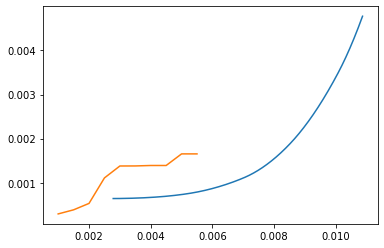

In [54]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)